# **Regularização - Regressão Ridge e Lasso**

* A regularização consiste em um método para reduzir o número de features da base de dados para impedir com que o modelo produzido seja ineficiente, tendencioso e também dificil de interpretar. Dentre os diferentes tipos de regularização está a regressão Ridge e a regressão Lasso. 

* A diferença entre esses dois métodos de regularização está no fato do termo de regularização estar em valor absoluto, o que causa um grande impacto pois a regressão Lasso pune não somente os valores altos mas também exclui variáveis que não são relevantes para o modelo. 

**Regressão Ridge**

* A regressão Ridge é basicamente um modelo de regressão linear regularizado. O parâmetro λ é um escalar que também deve ser aprendido, usando um método de cross validation. Essa regressão aplica restrição nos coeficientes w. O termo de penalidade lambda regulariza os coeficientes de forma que, se os coeficientes assumem valores grandes, a função de otimização é penalizada.

* Portanto, a Regressão Ridge reduz os coeficientes e ajuda a reduzir a complexidade e a multicolinearidade do modelo. Caso lambda seja zero então a função de custo se torna semelhante à função de custo de regressão linear.


**Regressão LASSO**

* A Regressão LASSO é um método de seleção de variáveis e encolhimento para modelos de regressão linear. O objetivo da Regressão LASSO é obter o subconjunto de preditores que minimiza o erro de previsão para uma variável de resposta quantitativa. O algoritmo faz isso impondo uma restrição nos parâmetros do modelo que faz com que os coeficientes de regressão de algumas variáveis convirjam em direção a zero.

* Variáveis com um coeficiente de regressão igual a zero acabam sendo excluídas. 

# **Modelo de Regressão Ridge e Lasso**

* Dois modelos serão construídos com o intúito de aplicar a regressão Ridge e Lasso. 

* A base de dados utilizada pode ser encontrada no seguinte link:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

* Consiste em um dataset com 80 colunas e que tem como objetivo de prever o preço da venda das casas. 

In [1]:
# Carregando os arquivos csv pro Colab
from google.colab import files
uploaded = files.upload()

Saving teste.csv to teste.csv
Saving treino.csv to treino.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns # Criar gráficos
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew # Pacote científico para transformações aos dados
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.model_selection import cross_val_score

# Remover os avisos
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
# Armazenando as bases de dados
train = pd.read_csv('treino.csv')
test = pd.read_csv('teste.csv')

In [10]:
# Linhas e colunas do Dataframe
train.shape

(1460, 81)

In [12]:
# Exemplo de linhas da base de dados
train.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000


As bases de teste e treino serão concatenadas para que possam ser feitas as transformações. Após esse procedimento é que será feita a divisão entre teste e treino novamente. 

In [15]:
# Reunindo as bases de dados
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_data.head(6)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal


# **Pré-Processamento dos dados**

* Para poder aplicar os métodos de regressão é necessário colocar os dados próximos de uma distribuição normal.

In [20]:
# Aplicando a transformação de Log na variável target e removendo os valores NA
train['SalePrice'] = np.log1p(train['SalePrice'])
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [23]:
# Aplicando as transformações para todos os dados e reajustando as bases de treino e teste
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

X_train = all_data[:train.shape[0]]
x_test = all_data[:test.shape[0]]
y_train = train.SalePrice

In [39]:
# Função para cálculo da métrica do modelo, ou seja, cálculo da raiz quadrada do erro médio ao quadrado
def rmse_cv(modelo):
  rmse = np.sqrt(-cross_val_score(modelo,
                                  X_train,
                                  y_train,
                                  scoring='neg_mean_squared_error',
                                  cv = 5))
  return (rmse)

# **Criando um modelo de Regressão Linear Múltipla sem uso da regularização**

In [27]:
# Criação do modelo
modelo_lr = LinearRegression(normalize = False, fit_intercept = True)

In [28]:
# Treinando o modelo com os dados não normalizados, ou seja, em diferentes escalas
modelo_lr.fit(X_train, y_train)

LinearRegression(normalize=False)

In [40]:
# Erro médio do modelo
rmse_cv(modelo_lr).mean()

0.022774141499315566

# **Modelo da Regressão Ridge**

In [55]:
# Criação do modelo Ridge
modelo_ridge = Ridge()

In [57]:
# Cross Validation para encontrar os melhores valores dos parâmetros do modelo Ridge criado, ou seja, para o treinamento do modelo
cross_val_score(modelo_ridge,
                X_train,
                y_train,
                scoring='neg_mean_squared_error',
                cv = 5)

array([-1.06118285e-04, -1.43575502e-04, -1.39337620e-04, -9.32358989e-05,
       -1.50989209e-04])

In [58]:
# Cálculo do erro do modelo
rmse_ridge = np.sqrt(-cross_val_score(modelo_ridge,
                                      X_train,
                                      y_train,
                                      scoring='neg_mean_squared_error',
                                      cv = 5))
rmse_ridge.mean()

0.01120628973396361

* Percebe-se que o valor obtido do erro foi menor para a Regressão Ridge em comparação ao modelo sem a aplicação desse método.

# **Modelo com Regressão LASSO**

In [59]:
# Criação do modelo LASSO passando os valores do parâmetro Alpha e já treinando o modelo
modelo_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [60]:
# Erro médio do modelo
rmse_cv(modelo_lasso).mean()

0.012495387466705261

In [61]:
# Coeficientes LASSO
coef = pd.Series(modelo_lasso.coef_, index = X_train.columns)
coef.head()

MSSubClass    -0.000000
LotFrontage    0.000000
LotArea        0.000000
OverallQual    0.008427
OverallCond    0.002515
dtype: float64

Text(0.5, 1.0, 'Coeficientes no Modelo LASSO')

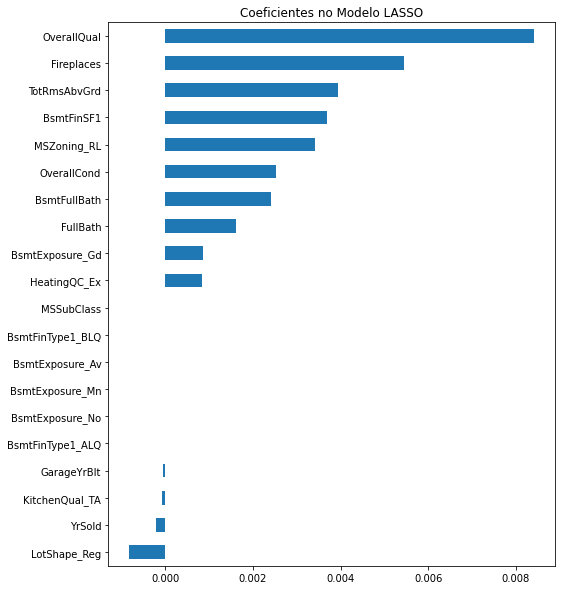

In [62]:
# Coeficientes LASSO mais relevantes e menos relevantes para o modelo
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coeficientes no Modelo LASSO")